# Discrete Data + Probability Exercises
### Kwame V. Taylor

When you have a variable that is not too noisy, you can have a baseline probability, then as new datapoints come in you can identify and compare the actual rate with the expected rate (probability).

* Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

### Imports

In [1]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

### Acquire

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


### Prepare

In [4]:
# parse datetime
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.destination.value_counts()

"https://python.zach.lol/"                                        4
"https://ds.codeup.com/8.3_Acquire/"                              3
"https://python.zach.lol/api/v1/"                                 2
"https://python.zach.lol/api/v1/stores?page=1"                    2
"http://localhost:8889/notebooks/timeseries_acquisition.ipynb"    1
"https://python.zach.lol/api/v1/stores?page=2"                    1
"https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!"                1
"https://python.zach.lol/api/v1/items?page=0"                     1
"https://python.zach.lol/api/V1/HiZach!"                          1
"http://localhost:8888/notebooks/acquire.ipynb"                   1
"https://python.zach.lol/api/v1/stores?page=999"                  1
"https://python.zach.lol/api/v1//api/v1/items?page=2"             1
"https://python.zach.lol/api/v1/sales?page=3"                     1
"https://python.zach.lol/api/v1/stores?page=0"                    1
"https://python.zach.lol/api/v1//api/v1/items"  

In [6]:
# clean up text

for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales?page=81 HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales?page=82 HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales?page=83 HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales?page=84 HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
# remove page numbers

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [8]:
# Add Variable - Converting bytes to mb

df['size_mb'] = [n/1024/1024 for n in df['size']]
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [9]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


### Detect Discrete Anomalies
**Finding anomalies in already existing data:**
We can easily see some anomalies around IP addresses.

In [12]:
# create IP df
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df = ip_df.merge(ip_df2)

ip_df.sort_values(by='ip_proba', ascending=False).head()

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


In [13]:
# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,35.175.171.137,2,0.000143
7,70.121.214.34,2,0.000143
8,52.87.230.102,2,0.000143
9,34.229.70.250,1,0.000072
10,45.23.250.16,1,0.000072
11,54.172.14.223,1,0.000072
12,34.207.64.242,1,0.000072
13,52.90.165.200,1,0.000072


**A great way to visualize outliers:**

22
               ip  ip_count  ip_proba
12  34.207.64.242         1  0.000072
13  52.90.165.200         1  0.000072
14   3.88.129.158         1  0.000072
15  97.105.15.120         1  0.000072
16   3.92.201.136         1  0.000072
17  54.145.52.184         1  0.000072
18   52.91.30.150         1  0.000072
19   95.31.18.119         1  0.000072
20   35.174.209.2         1  0.000072
21   95.31.16.121         1  0.000072


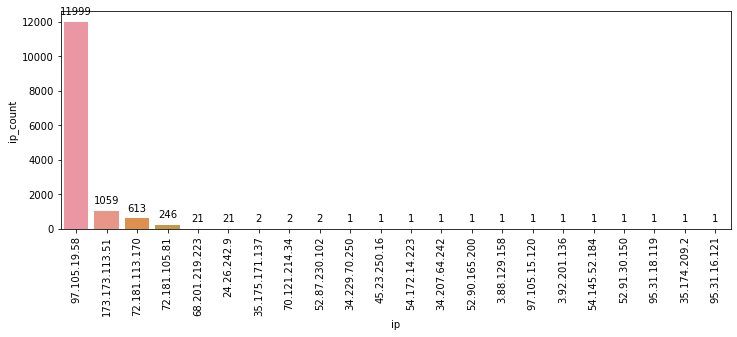

In [14]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.
**Establish Baseline:**

In [15]:
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]

**Compute probabilities based on train sample:**

In [16]:
# Probability of discrete/categorical occurence
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df.head()

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503


**Merge probabilities with all data (train + new data):**
* Where the IP address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [17]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595


In [18]:
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

### Conditional Probabilities: Probabilities using 2 discrete variables¶
**Probability of Status given IP Address:** If we are looking for an unexpected status (like authentication failure) from a known/common IP address.

In [19]:
ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )
status_given_ip

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000286
1,24.26.242.9,200,1.000286
2,3.88.129.158,200,1.000286
3,3.92.201.136,200,1.000286
4,34.207.64.242,200,1.000286
5,34.229.70.250,200,1.000286
6,35.174.209.2,200,1.000286
7,35.175.171.137,200,1.000286
8,45.23.250.16,200,1.000286
9,52.87.230.102,200,1.000286


In [20]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)
ip_status.sort_values(by="ip_status_count", ascending=False)

,ip,status,proba_status_given_ip,ip_status_count
19,97.105.19.58,200,0.999119,11984
0,173.173.113.51,200,1.000286,1059
17,72.181.113.170,200,0.997023,611
16,72.181.105.81,200,1.000286,246
1,24.26.242.9,200,1.000286,21
14,68.201.219.223,200,1.000286,21
20,97.105.19.58,499,0.001167,14
7,35.175.171.137,200,1.000286,2
9,52.87.230.102,200,1.000286,2
15,70.121.214.34,200,1.000286,2


**Add these probabilities to original events to detect anomalous events:**

In [22]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0


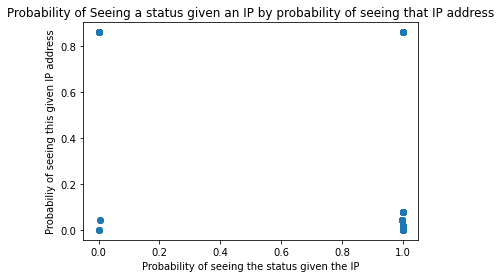

In [24]:
plt.title("Probability of Seeing a status given an IP by probability of seeing that IP address")
plt.xlabel("Probability of seeing the status given the IP")
plt.ylabel("Probabiliy of seeing this given IP address")
plt.scatter(df.proba_status_given_ip, df.ip_proba)